In [1]:
import os
import subprocess
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
# subprocess.run(['source', '/home/masonbp/.bashrc'])
# subprocess.run(['setup_ros'])
# os.system('sh ~/.rosrc')
# subprocess.call(['bash', '/home/masonbp/.rosrc'])
# subprocess.call(['bash', '/home/masonbp/.rosrc'])
sys.path.append('/opt/ros/noetic/lib/python3/dist-packages')
sys.path.append('/home/masonbp/code/')

from robot_utils.robot_data import ImgData
from segment_track.fastsam_wrapper import FastSAMWrapper

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
params = {
    'time': {
        't0': 200, 
        'tf': 400, 
        'relative': True,
    },
    'img_data': {
        'path': "$KMD_BAGS_PATH/sparkal1.bag",
        'img_topic': "/sparkal1/forward/color/image_raw/compressed",
        'cam_info_topic': "/sparkal1/forward/color/camera_info"
    },
    'fastsam':{
        'weights': "$FASTSAM_WEIGHTS_PATH",
        'imgsz': 512,
        'device': "cuda",
        'ignore_people': True
    }
}
if 'min_mask_len_div' not in params['fastsam']:
    params['fastsam']['min_mask_len_div'] = 30
if 'max_mask_len_div' not in params['fastsam']:
    params['fastsam']['max_mask_len_div'] = 5

In [3]:
img_file_path = os.path.expanduser(os.path.expandvars(params["img_data"]["path"]))
if 'time' in params:
    if 'relative' in params['time'] and params['time']['relative']:
        topic_t0 = ImgData.topic_t0(img_file_path, params["img_data"]["img_topic"])
        time_range = [topic_t0 + params['time']['t0'], topic_t0 + params['time']['tf']]
    else:
        time_range = [params['time']['t0'], params['time']['tf']]
else:
    time_range = None

print(f"Time range: {time_range}")
img_data = ImgData(
    data_file=img_file_path,
    file_type='bag',
    topic=params["img_data"]["img_topic"],
    time_tol=.02,
    time_range=time_range
)
img_data.extract_params(params['img_data']['cam_info_topic'])


Time range: [1665777796.8772979, 1665777996.8772979]


(array([[     380.81,           0,      315.85],
        [          0,      380.54,      238.04],
        [          0,           0,           1]]),
 array([  -0.054963,    0.064489,  0.00020229,  0.00045873,   -0.020386]))

In [4]:
fastsam = FastSAMWrapper(
    weights=os.path.expanduser(os.path.expandvars(params['fastsam']['weights'])),
    imgsz=params['fastsam']['imgsz'],
    device=params['fastsam']['device'],
    # mask_downsample_factor=params['segment_tracking']['mask_downsample_factor']
)
img_area = img_data.camera_params.width * img_data.camera_params.height
fastsam.setup_filtering(
    ignore_people=params['fastsam']['ignore_people'],
    yolo_det_img_size=(128, 128) if params['fastsam']['ignore_people'] else None,
    allow_tblr_edges=[True, True, True, True],
    area_bounds=[img_area / (params['fastsam']['min_mask_len_div']**2), img_area / (params['fastsam']['max_mask_len_div']**2)]
)

INFO - 2024-04-18 14:46:06,825 - torch_utils - Model Summary: 407 layers, 37620125 parameters, 37620125 gradients


Fusing layers... 


<Axes: >

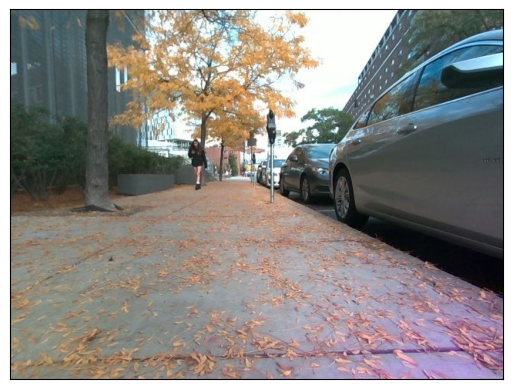

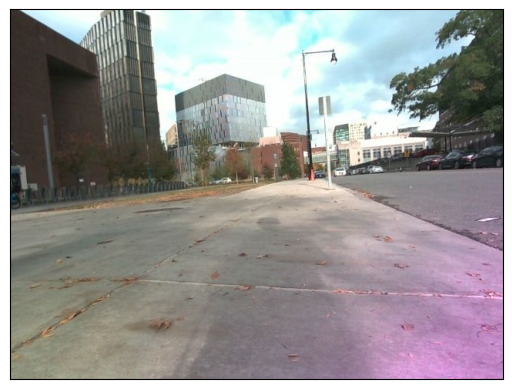

In [5]:
img_data.show(img_data.t0+170)
img_data.show(img_data.tf)

In [6]:
t = img_data.t0 + 170
img = img_data.img(t)
observations = fastsam.run(t, np.eye(4), img)

/home/masonbp/.envs/sparse_map/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

0: 384x512 16 objects, 59.4ms
Speed: 2.0ms preprocess, 59.4ms inference, 26.1ms postprocess per image at shape (1, 3, 512, 512)


In [7]:
def show_observation(img, observations, show_id=False):

    for i, obs in enumerate(observations):
        colored_mask = np.zeros_like(img)
        rand_color = np.random.randint(0, 255, 3)
        colored_mask = obs.mask.astype(np.int32)[..., np.newaxis]*rand_color
        colored_mask = colored_mask.astype(np.uint8)
        img = cv.addWeighted(img, 1.0, colored_mask, 0.5, 0)
        if show_id:
            img = cv.putText(img, str(i), obs.pixel.astype(np.int32), 
                cv.FONT_HERSHEY_SIMPLEX, 0.5, rand_color.tolist(), 2)
    return img

def show_obs_sim(img, obs1, obs2):
    ret = np.zeros_like(img)
    rand_color = np.random.randint(0, 255, 3)
    colored_mask = obs1.mask.astype(np.int32)[..., np.newaxis]*rand_color
    colored_mask = colored_mask.astype(np.uint8)
    ret = cv.addWeighted(ret, 1.0, colored_mask, 0.5, 0)
    rand_color = np.random.randint(0, 255, 3)
    colored_mask = obs2.mask.astype(np.int32)[..., np.newaxis]*rand_color
    colored_mask = colored_mask.astype(np.uint8)
    ret = cv.addWeighted(ret, 1.0, colored_mask, 0.5, 0)
    return ret


0: 384x512 16 objects, 22.0ms
Speed: 1.0ms preprocess, 22.0ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


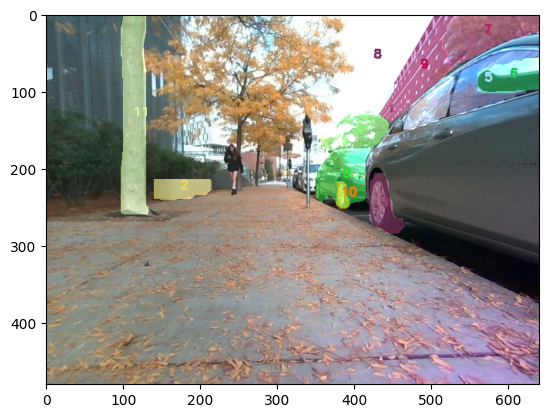

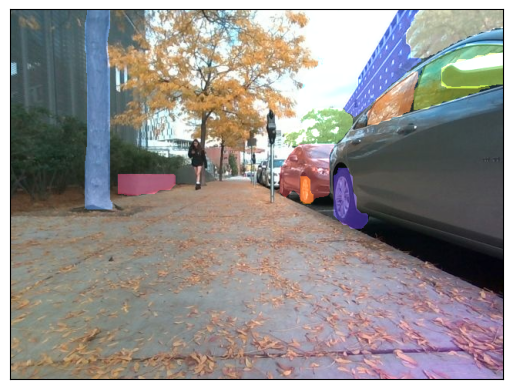

In [8]:
t = img_data.t0 + 170
img = img_data.img(t)
observations = fastsam.run(t, np.eye(4), img)

img = show_observation(img, observations, show_id=True)
plt.imshow(img[...,::-1])
plt.show()

img = img_data.img(t)
img = show_observation(img, observations, show_id=False)
fig, ax = plt.subplots()
ax.imshow(img[...,::-1])
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)


0: 384x512 15 objects, 22.0ms
Speed: 0.9ms preprocess, 22.0ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


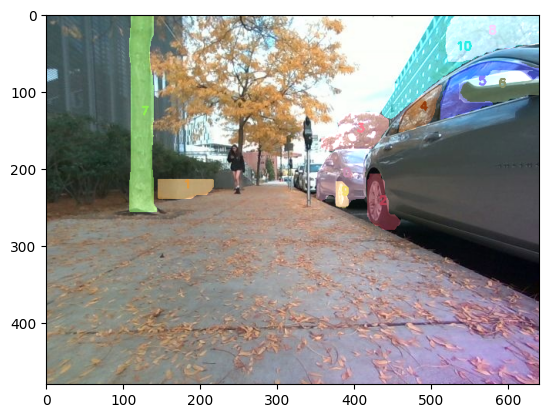

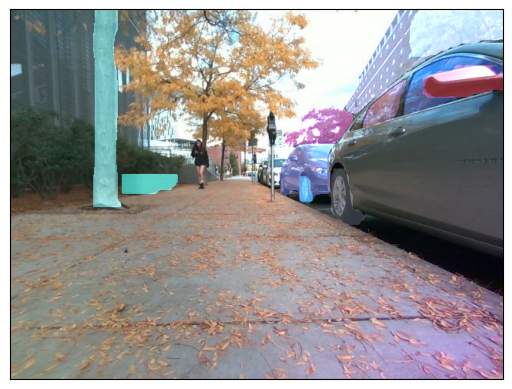

In [9]:
t = img_data.t0 + 169.9
img = img_data.img(t)
observations2 = fastsam.run(t, np.eye(4), img)

img = show_observation(img, observations2, show_id=True)
plt.imshow(img[...,::-1])
plt.show()

img = img_data.img(t)
img = show_observation(img, observations2, show_id=False)
fig, ax = plt.subplots()
ax.imshow(img[...,::-1])
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

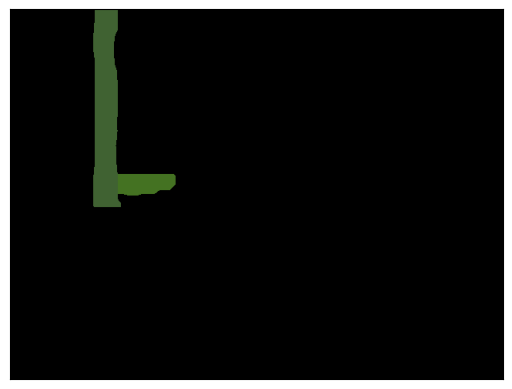

In [10]:
img = show_obs_sim(img, observations[11], observations2[7])
img = show_obs_sim(img, observations[2], observations2[7])
fig, ax = plt.subplots()
ax.imshow(img[...,::-1])
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)


0: 384x512 16 objects, 21.9ms
Speed: 0.9ms preprocess, 21.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


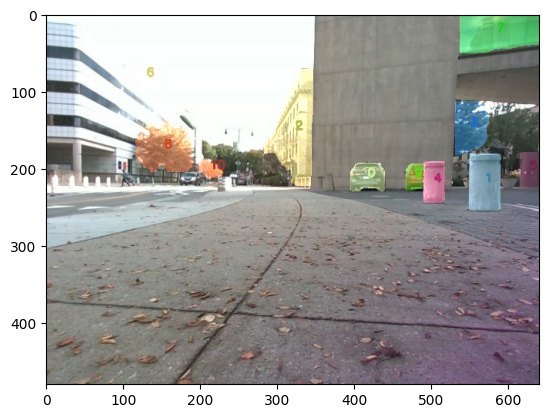

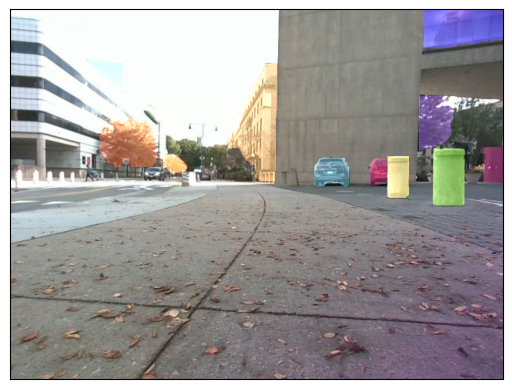

In [12]:
t = img_data.t0 + 20
img = img_data.img(t)
observations2 = fastsam.run(t, np.eye(4), img)

img = show_observation(img, observations2, show_id=True)
plt.imshow(img[...,::-1])
plt.show()

img = img_data.img(t)
img = show_observation(img, observations2, show_id=False)
fig, ax = plt.subplots()
ax.imshow(img[...,::-1])
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)